#   IAU Zadanie - II. fáza

### Autori: Peter Brandajsky - 50%, Frederik Duvač - 50%

# Načítanie údajov z datasetu

Dataset sme si exportli, nakonci fázy 1, kde sme spojili **connections_mean_median** a **processes_mean_median** na **imei** a **ts** stĺpcoch, čo boli naše upravené datasety s imputáciou missing values.

In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

dataset = pd.read_csv('dataset/dataset_phase_2.csv', sep='\t')

In [120]:
dataset.head()

,ts,imei,mwra,c.android.gm,c.android.chrome,c.dogalize,c.katana,c.android.youtube,c.android.vending,c.updateassist,...,p.process.gapps,p.katana,p.gms.persistent,p.android.defcontainer,p.browser.provider,p.simulator,p.notifier,p.android.vending,p.dogalize,p.android.gms
0,2018-05-05 10:00:00,3590433799317661479,0.0,7.58999,10.10690,13.15797,9.38358,12.97598,36.79370,52.292355,...,31.46173,75.73633,17.18109,28.63863,86.03245,87.66743,22.50267,62.67423,85.26363,47.83375
1,2018-05-05 10:01:00,3590433799317661115,1.0,13.90744,11.08136,10.56072,11.35434,13.32609,45.54295,25.353440,...,57.78407,88.65165,0.35403,37.70733,50.73157,22.83300,20.08413,45.59394,42.29871,32.98469
2,2018-05-05 10:02:00,359043379931766155,0.0,12.07737,9.28159,11.69018,9.33765,13.66042,31.33313,57.102670,...,39.65381,80.18738,92.40107,69.92029,58.19673,77.88785,71.49623,9.73326,12.17514,79.96124
3,2018-05-05 10:03:00,3590433799317661040,0.0,11.93742,9.87723,14.49817,10.41657,15.17780,32.24723,67.041760,...,47.65908,65.78662,8.17850,21.81412,28.87156,70.59531,19.30408,28.30924,85.76963,90.10998
4,2018-05-05 10:04:00,8630330696303481669,1.0,7.91094,14.34135,11.03992,16.50329,7.84216,63.95286,65.506340,...,47.05190,32.27816,35.86468,93.24048,16.82238,3.86695,19.23138,72.90849,75.26363,81.45468


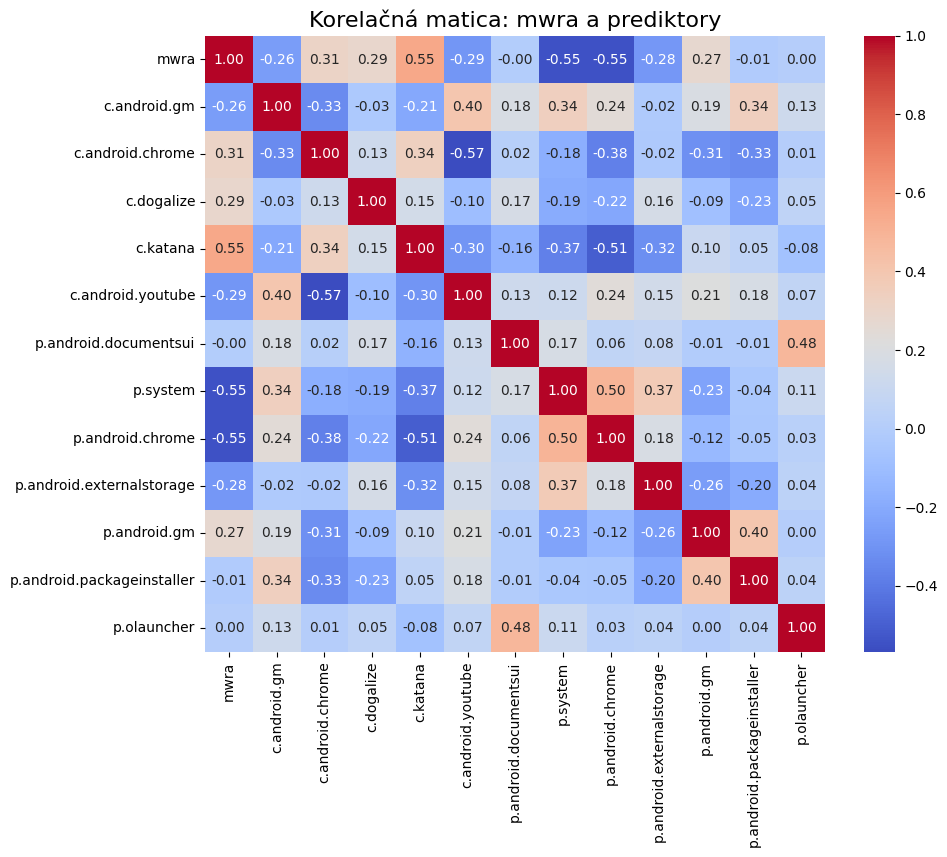

In [121]:
dataset = dataset[
    ['mwra', 'c.android.gm', 'c.android.chrome', 'c.dogalize', 'c.katana', 'c.android.youtube', 'p.android.documentsui',
     'p.system', 'p.android.chrome', 'p.android.externalstorage',
     'p.android.gm', 'p.android.packageinstaller', 'p.olauncher']]

plt.figure(figsize=(10, 8))
sns.heatmap(dataset.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Korelačná matica: mwra a prediktory', fontsize=16)
plt.show()

Drop nepotrebnych stlpcov, pri ktorých je nulova alebo zaporna korelácia k predikovanej premennej.

In [122]:
dataset.drop(columns=['c.android.gm', 'c.android.youtube', 'p.android.documentsui', 'p.system', 'p.android.chrome',
                      'p.android.externalstorage', 'p.android.packageinstaller', 'p.olauncher'], inplace=True)

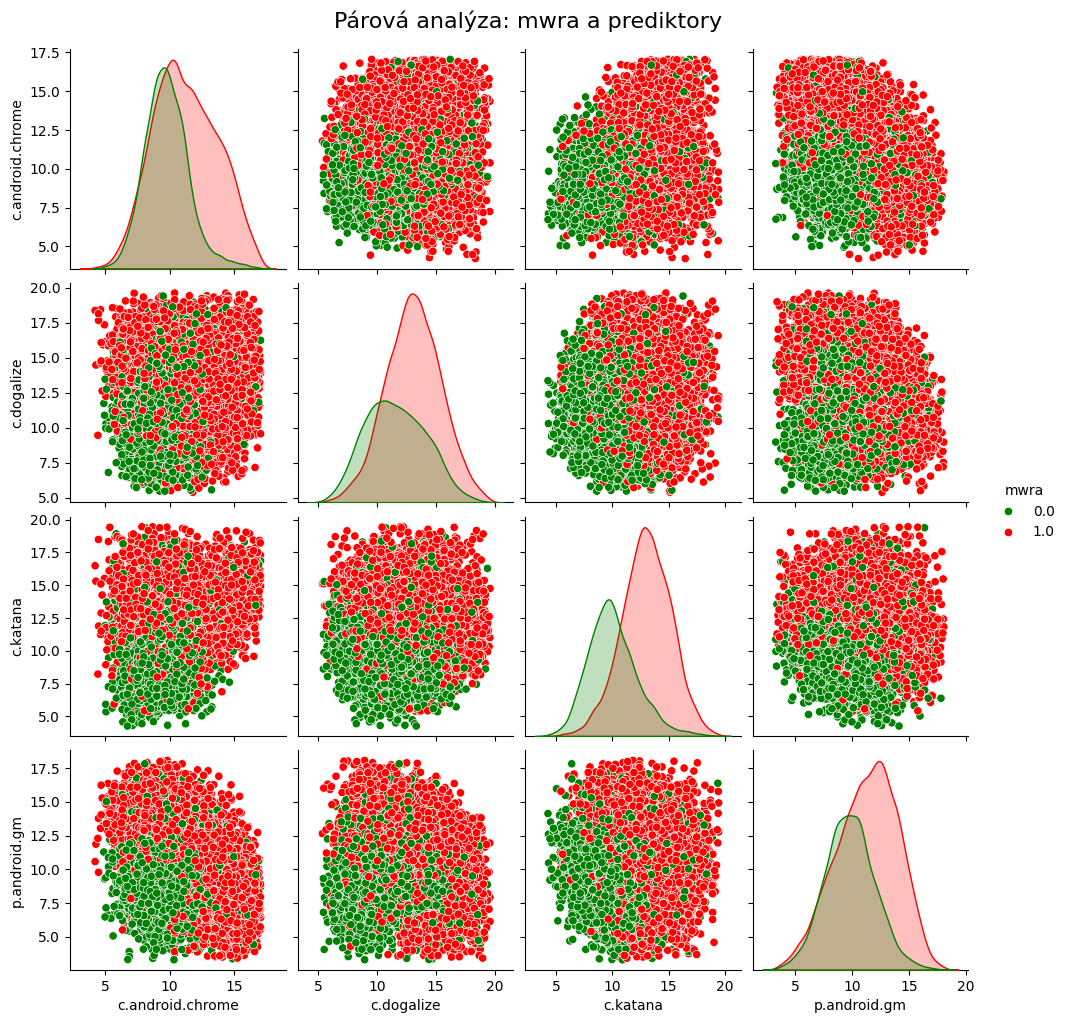

In [123]:
sns.pairplot(dataset, diag_kind='kde', hue='mwra', palette={0.0: 'green', 1.0: 'red'})
plt.suptitle('Párová analýza: mwra a prediktory', fontsize=16, y=1.02)
plt.show()

In [124]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14884 entries, 0 to 14883
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   mwra              14884 non-null  float64
 1   c.android.chrome  14884 non-null  float64
 2   c.dogalize        14884 non-null  float64
 3   c.katana          14884 non-null  float64
 4   p.android.gm      14884 non-null  float64
dtypes: float64(5)
memory usage: 581.5 KB


# 2.1 Realizácia predspracovania dát

## 2.1.A

In [125]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(
    dataset,
    test_size=0.2,
    random_state=42,
    stratify=dataset['mwra']  # Toto zabezpečí rovnakú distribúciu tried
)

# Kontrola distribúcie tried
print("Kontrola distribúcie tried:\n")
print("Pôvodný dataset:")
print(dataset['mwra'].value_counts(normalize=True).round(6))

print("\nTrénovacia množina:")
print(train_data['mwra'].value_counts(normalize=True).round(6))

print("\nTestovacia množina:")
print(test_data['mwra'].value_counts(normalize=True).round(6))

# Kontrola absolútnych počtov
print("\nAbsolútne počty:")
print(f"Celkový počet vzoriek: {len(dataset)}")
print(f"Počet trénovacích vzoriek: {len(train_data)} ({len(train_data)/len(dataset)*100:.1f}%)")
print(f"Počet testovacích vzoriek: {len(test_data)} ({len(test_data)/len(dataset)*100:.1f}%)")

Kontrola distribúcie tried:

Pôvodný dataset:
mwra
1.0    0.626512
0.0    0.373488
Name: proportion, dtype: float64

Trénovacia množina:
mwra
1.0    0.626522
0.0    0.373478
Name: proportion, dtype: float64

Testovacia množina:
mwra
1.0    0.62647
0.0    0.37353
Name: proportion, dtype: float64

Absolútne počty:
Celkový počet vzoriek: 14884
Počet trénovacích vzoriek: 11907 (80.0%)
Počet testovacích vzoriek: 2977 (20.0%)


## 2.1.B

#### Kontrola formátu dát

In [126]:
print(f"Počet pozorovaní (riadkov): {len(train_data)}")
print(f"Počet atribútov (stĺpcov): {len(train_data.columns)}")
print("\nTypy dát v stĺpcoch:")
print(train_data.dtypes)

Počet pozorovaní (riadkov): 11907
Počet atribútov (stĺpcov): 5

Typy dát v stĺpcoch:
mwra                float64
c.android.chrome    float64
c.dogalize          float64
c.katana            float64
p.android.gm        float64
dtype: object


#### Kontrola chýbajúcich hodnôt

In [127]:
missing_values = train_data.isnull().sum()
print("Počet chýbajúcich hodnôt v každom stĺpci:")
print(missing_values)

Počet chýbajúcich hodnôt v každom stĺpci:
mwra                0
c.android.chrome    0
c.dogalize          0
c.katana            0
p.android.gm        0
dtype: int64


#### Kontrola a spracovanie outlierov pomocou IQR


Spracovanie outlierov:

Stĺpec c.android.chrome:
Počet outlierov: 15
Percento outlierov: 0.13%

Stĺpec c.dogalize:
Počet outlierov: 0
Percento outlierov: 0.00%

Stĺpec c.katana:
Počet outlierov: 1
Percento outlierov: 0.01%

Stĺpec p.android.gm:
Počet outlierov: 0
Percento outlierov: 0.00%


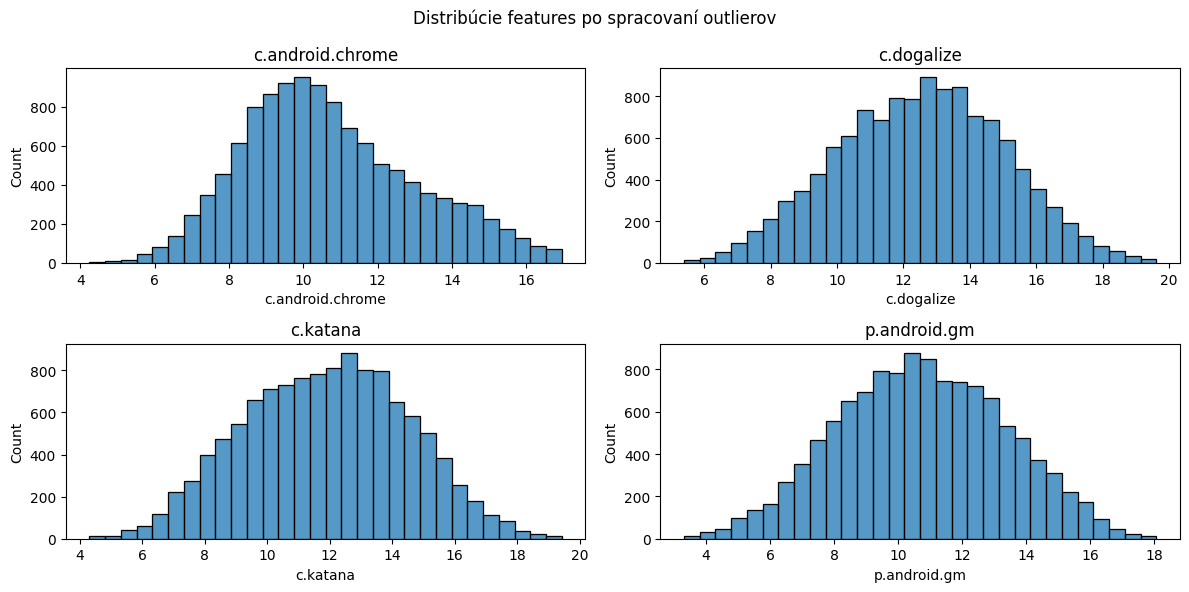

In [ ]:
def handle_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Počet outlierov
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
    print(f"\nStĺpec {column}:")
    print(f"Počet outlierov: {len(outliers)}")
    print(f"Percento outlierov: {(len(outliers)/len(df)*100):.2f}%")
    
    # Nahradenie outlierov hraničnými hodnotami
    df.loc[df[column] < lower_bound, column] = lower_bound
    df.loc[df[column] > upper_bound, column] = upper_bound
    
    return df

# Spracovanie outlierov pre každý numerický stĺpec okrem target premennej
print("\nSpracovanie outlierov:")
for column in train_data.select_dtypes(include=['float64', 'int64']).columns:
    if column != 'mwra': 
        train_data = handle_outliers(train_data, column)

# Vizualizácia distribúcií po spracovaní outlierov
plt.figure(figsize=(12, 6))
plt.suptitle('Distribúcie features po spracovaní outlierov')
for i, column in enumerate(train_data.drop('mwra', axis=1).columns):
    plt.subplot(2, 2, i+1)
    sns.histplot(train_data[column], bins=30)
    plt.title(column)
plt.tight_layout()
plt.show()

#### Vytvorenie pipeline s kompletným predspracovaním

In [129]:
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import RobustScaler

# # Rozdelenie na features a target
# X_train = train_data.drop('mwra', axis=1)
# y_train = train_data['mwra']


# # Preprocessing pipeline pre features
# pipeline = Pipeline([
#     ('robust_scaler', RobustScaler())
# ])

# # Fit a transform features
# X_transformed = pipeline.fit_transform(X_train)

# train_data_transformed = pd.DataFrame(
#     X_transformed, 
#     columns=X_train.columns,
#     index=X_train.index
# )
# train_data_transformed['mwra'] = y_train

# print("Kontrola dát po transformácii:")
# print("\nTypy dát:")
# print(train_data_transformed.dtypes)

# print("\nZákladné štatistiky:")
# print(train_data_transformed.describe())

# print("\nDistribúcia cieľovej premennej:")
# print(train_data_transformed['mwra'].value_counts(normalize=True))

# train_data = train_data_transformed

## 2.1.C

## 2.1.D

# 2.2 Výber atribútov pre strojové učenie

## 2.2.A

## 2.2.B

## 2.2.C

# 2.3 Replikovateľnosť predspracovania

## 2.3.A

## 2.3.B